## Activity 07
### Tyler Barna

In [1]:
## import modules (running on python 3.9.12)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pymc3 as pm
import random
import scipy
import seaborn as sns


import scipy.stats as stats
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import multivariate_normal as mvn

from astropy.io import fits
from astropy.io import ascii
cm = plt.cm.get_cmap('RdYlBu')

## set seed for reproducibility
random.seed(5731) 

## import data
ceph_df = pd.read_csv('./cepheid_data.csv')
df = pd.read_csv('./fundamental_plane_kpc.csv')

display(ceph_df.describe())
display(df.describe())

,angDist,_RAJ2000,_DEJ2000,Period,Vmag,E_B-V_,__Fe_H_3,_RA,_DE,recno,id,RA_ICRS,DE_ICRS,rest,b_rest,B_rest,rlen,ResFlag,ModFlag
count,449.000000,449.000000,449.000000,449.00000,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,4.490000e+02,449.000000,449.000000,449.000000,449.000000,449.000000,449.000000,449.0,449.0
mean,0.073825,184.039867,3.004844,8.68835,10.099597,0.559457,0.038909,184.039867,3.004843,226.701559,3.310859e+18,184.039853,3.004840,3191.552341,2758.372055,3789.578861,1372.083476,1.0,1.0
std,0.087028,105.533720,44.913304,8.77079,2.228622,0.322800,0.120358,105.533720,44.913303,130.509784,1.930746e+18,105.533723,44.913298,2158.408040,1731.349807,2778.791662,324.601675,0.0,0.0
min,0.001847,0.246827,-70.151790,0.92200,3.700000,0.025000,-0.680000,0.246830,-70.151790,1.000000,1.744891e+17,0.246799,-70.151795,242.276663,239.525677,245.090419,532.061183,1.0,1.0
25%,0.030049,98.477540,-42.568157,4.19800,8.630000,0.310000,0.000000,98.477540,-42.568160,114.000000,2.006989e+18,98.477542,-42.568144,1734.914094,1604.356619,1890.889795,1141.923825,1.0,1.0
50%,0.062153,165.566940,4.073567,5.89800,10.220000,0.530000,0.000000,165.566930,4.073570,227.000000,3.346585e+18,165.566882,4.073569,2750.256043,2459.193623,3061.745368,1332.591144,1.0,1.0
75%,0.098141,286.692320,45.478615,10.14200,11.810000,0.735000,0.110000,286.692320,45.478620,339.000000,5.324035e+18,286.692301,45.478606,4118.178972,3515.011129,4949.375917,1563.934923,1.0,1.0
max,1.000589,359.574900,68.888504,96.29000,14.400000,2.059000,0.470000,359.574900,68.888500,452.000000,6.060173e+18,359.574871,68.888467,12888.728001,10516.199583,16310.235952,2486.181213,1.0,1.0


,ID,A_R,LogRe,mue,logSigma,eLogSigma,velocity,Type
count,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,49.640401,0.162911,0.526437,19.486920,2.254963,0.026850,7971.922636,-3.717765
std,28.808444,0.124168,0.305982,0.768645,0.150534,0.009911,3027.429422,1.392437
min,0.000000,0.015000,-0.385867,17.020000,1.720000,0.008000,2089.000000,-5.000000
25%,25.000000,0.060250,0.337553,18.982500,2.155250,0.020000,5413.500000,-5.000000
50%,50.000000,0.144000,0.510618,19.450000,2.273000,0.026000,7869.000000,-4.000000
75%,74.750000,0.209000,0.701511,19.940000,2.365000,0.033500,9951.000000,-2.000000
max,99.000000,0.605000,1.830392,22.550000,2.600000,0.056000,15799.000000,-2.000000


Following the guideline notebook and taking

\begin{equation}
x = 0.205 \mu_e + \text{log}\left(\sigma\right)
\end{equation}

where $\mu_e$ is the mean R-band surface brightness within the effective radius and $\text{log}\left(\sigma\right)$ iss the log of the central velocity dispersion; we can plot the data and fit a line to it. the y is taken to be

\begin{equation}
y = \text{log}\left(R_e\right)
\end{equation}

where $\text{log}\left(R_e\right)$ is the log of the effective radius in kpc. I also assign a colormap that corresponds to the type of galaxy, where Type $\ge$ -4 corresponds to Ellipticals and $-3\le$ Type $\le-1$ corresponds to S0

shape of X:  (698, 2)
shape of y:  (698,) 

mle estimator:  [[-8.15618211  1.38926761]]


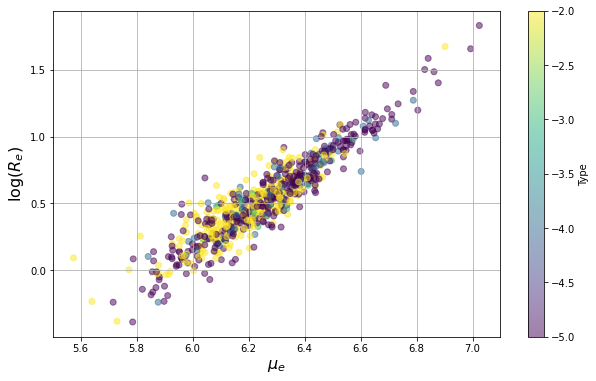

In [5]:
## setup matrices
x, y = (0.205*df['mue']+df['logSigma'], 
        df['LogRe']) 
x2 = df['logSigma']
X = np.matrix([np.ones(x.shape[0]), x]).T

print('shape of X: ',X.shape)
print('shape of y: ',y.shape,'\n')

## mle estimator
p_mat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print('mle estimator: ',p_mat)

## define xx and yy variable for plotting
xx = np.linspace(17, 23, 100)
yy = np.array(p_mat[0,0] + p_mat[0,1]*xx)

fig, ax = plt.subplots(figsize=(10, 6),facecolor='white')
ax.set_xlabel(r'$\mu_e$',fontsize=16)
ax.set_ylabel(r'$\log(R_e)$',fontsize=16)
ax.grid()

scat = ax.scatter(x, y, c=df['Type'], alpha=0.5)
cbat = plt.colorbar(scat)
cbat.set_label(r'Type')

# logSigma = np.linspace(17,23,x.shape[0])
# ax.plot(logSigma, logSigma+0.205*x, lw=6,color='black')